In [1]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, T5ForConditionalGeneration
import torch
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import SmoothingFunction
import nltk
import os
import seaborn as sns
import re

/Users/adamwagnerhoegh/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# reading the dev set
file_path = "../output/devset/devset_with_contexts.parquet.gzip"
with open(file_path, "rb") as f:
    dev_set = pd.read_parquet(f)

#### Data reading functions

In [3]:
# pasting functions from the data_functions.py file
def replace_nbsp(obj):
    """
    Recursively replaces non-breaking space characters (\xa0) with regular spaces
    in strings within nested data structures.
    
    Args:
        obj: Input object which can be a dictionary, list, string or other type
        
    Returns:
        Object of same structure as input but with \xa0 replaced with spaces in all strings
    """
    if isinstance(obj, dict):
        return {k: replace_nbsp(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [replace_nbsp(i) for i in obj]
    elif isinstance(obj, str):
        return obj.replace('\xa0', ' ')
    else:
        return obj

def generate_paragraphs(input_file):
    """
    Generates a list of dictionaries containing paragraph information from legal documents.
    
    Args:
        input_file: Path to input JSON file containing legal document data
        output_file: Path to output file to write the processed data
        
    Returns:
        rag_list: List of dictionaries, where each dictionary contains:
            - paragraf_nr: Paragraph number
            - lovnavn: Name of the law
            - text: Combined text of all subsections in the paragraph
    """
    with open(input_file) as f:
        retsinfo = json.load(f)

    paragraphs = []
    idx = 0
    for lov in retsinfo:
        for kapitel in lov['kapitler']:
            lov_navn = lov['shortName']
            for paragraffer in kapitel['paragraffer']:
                temp_paragraf_dict = {}
                temp_paragraf_dict['paragraf_nr'] = paragraffer['nummer']
                temp_paragraf_dict['lovnavn'] = lov_navn
                temp_paragraf_list = []
                for styk in paragraffer['stk']:
                    temp_paragraf_list.append(styk['tekst'])
                temp_paragraf_dict['text'] = ' '.join(temp_paragraf_list)
                paragraphs.append(temp_paragraf_dict)

    paragraphs = replace_nbsp(paragraphs)
    return paragraphs

#### Measure mean token length of output

In [9]:
# creating a dict
model_answers = {}
for file in os.listdir('../output/inference'):
        # iterating through and creating model names
        if file.endswith('.txt'):
            model_name = file.replace(".txt", "")
            with open(f"../output/inference/{file}", "r") as f:
                model_answers[model_name] = f.read().splitlines()
                print(f"Loaded answers from model: {model_name}")

Loaded answers from model: neo_gen_bert_max_k2
Loaded answers from model: t5_gen_bert_mean_k1
Loaded answers from model: t5_gen_random_context
Loaded answers from model: neo_gen_bert_max_k3
Loaded answers from model: neo_gen_bert_max_k1
Loaded answers from model: t5_gen_bert_mean_k3
Loaded answers from model: t5_gen_bert_mean_k2
Loaded answers from model: t5_gen_bert_cls_k3
Loaded answers from model: t5_gen_bert_cls_k2
Loaded answers from model: t5_gen_bert_cls_k1
Loaded answers from model: neo_gen_random_context
Loaded answers from model: neo_gen_upper_bound
Loaded answers from model: t5_gen_tfidf_k2
Loaded answers from model: t5_gen_tfidf_k3
Loaded answers from model: neo_gen_baseline
Loaded answers from model: t5_gen_tfidf_k1
Loaded answers from model: t5_gen_bert_max_k1
Loaded answers from model: t5_gen_bm25_k2
Loaded answers from model: t5_gen_bm25_k3
Loaded answers from model: t5_gen_bert_max_k2
Loaded answers from model: t5_gen_bm25_k1
Loaded answers from model: t5_gen_bert_max_

In [10]:
neo_tokenizer = AutoTokenizer.from_pretrained('KennethTM/gpt-neo-1.3B-danish')
t5_tokenizer = AutoTokenizer.from_pretrained('strombergnlp/dant5-large')

# creating a dictionary with mean output lengths for all the models
mean_len_dict = {}
for key in tqdm(model_answers):
    # passing for bert_mean due to a data error
    if re.search('mean', key) != None:
        pass
    elif str(key)[:3] == 'neo':
        temp_list = []
        for answer in model_answers[key]:
            temp_list.append(len(neo_tokenizer.tokenize(answer)))
        mean_len_dict[key] = np.mean(temp_list)
    elif str(key[:2]) == 't5':
        temp_list = []
        for answer in model_answers[key]:
            temp_list.append(len(t5_tokenizer.tokenize(answer)))
        mean_len_dict[key] = np.mean(temp_list)
    else:
        print('fail')

# sorting keys 
myKeys = list(mean_len_dict.keys())
myKeys.sort()

# sorted Dictionary
mean_len_dict = {i: mean_len_dict[i] for i in myKeys}

/Users/adamwagnerhoegh/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 36/36 [00:00<00:00, 84.94it/s] 


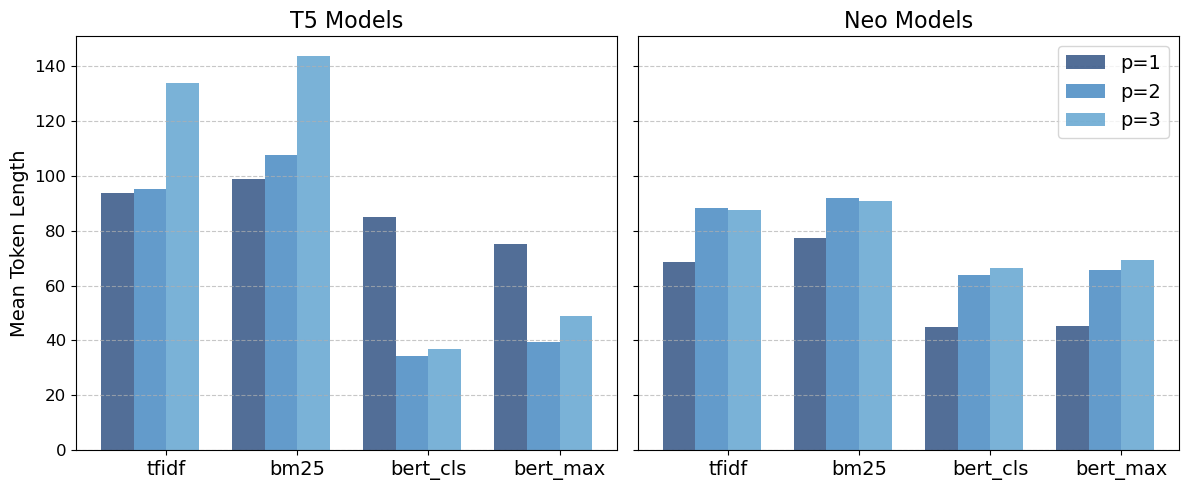

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# creating function to plot the mean token length of answers in subplots

def plot_token_lengths_subplots(results):
    """
    Plots the mean token lengths for T5 and Neo models across different retrievers in two subplots.

    Parameters:
        results (dict): A dictionary where keys are model names and values are mean token lengths.
    """
    # define retrievers and separate results by model type
    retrievers = ['tfidf', 'bm25', 'bert_cls', 'bert_max']
    t5_data = {k: v for k, v in results.items() if k.startswith('t5')}
    neo_data = {k: v for k, v in results.items() if k.startswith('neo')}

    # aggregate results by retriever for k1, k2, and k3
    retriever_means_t5 = {retriever: [t5_data.get(f't5_gen_{retriever}_k{k}', 0) for k in range(1, 4)] for retriever in retrievers}
    retriever_means_neo = {retriever: [neo_data.get(f'neo_gen_{retriever}_k{k}', 0) for k in range(1, 4)] for retriever in retrievers}

    # create positions for the bars
    x = np.arange(len(retrievers))
    width = 0.25  # Width of the bar groups

     # define color shades for bars
    t5_colors = ['#08306b', '#2171b5', '#4292c6', '#6baed6', '#9ecae1']  # Different blue shades from dark to light
    neo_colors = ['#08306b', '#2171b5', '#4292c6', '#6baed6', '#9ecae1']  # Same blue shades

    # set up the subplots
    fig, (ax_t5, ax_neo) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    #fig.suptitle('Mean token length of answers')

    # plot T5 data
    for i, p in enumerate(range(1, 4)):  # k1, k2, k3
        t5_means = [retriever_means_t5[retriever][i] for retriever in retrievers]
        ax_t5.bar(x + i * width - width, t5_means, width, label=f'p={p}', color=t5_colors[i], alpha=0.7)

    ax_t5.set_title('T5 Models', fontsize=16)
    ax_t5.set_ylabel('Mean Token Length', fontsize=14)
    ax_t5.set_xticks(x + width / 2)
    ax_t5.set_xticklabels(retrievers, fontsize=14)
    ax_t5.tick_params(axis='y', labelsize=12)
    ax_t5.grid(axis='y', linestyle='--', alpha=0.7)

    # plot Neo data
    for i, p in enumerate(range(1, 4)):  # k1, k2, k3
        neo_means = [retriever_means_neo[retriever][i] for retriever in retrievers]
        ax_neo.bar(x + i * width - width, neo_means, width, label=f'p={p}', color=neo_colors[i], alpha=0.7)

    ax_neo.set_title('Neo Models', fontsize=16)
    ax_neo.set_xticks(x + width / 2)
    ax_neo.set_xticklabels(retrievers, fontsize=14)
    ax_neo.legend(fontsize=14)
    ax_neo.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('../output/plots/mean_output_len.pdf', format='pdf')
    plt.show()

plot_token_lengths_subplots(mean_len_dict)


#### Count mean token length of retrieved documents

In [39]:
# creating a dict to store retrievals by retriever
retrievals = {}

# subsetting 
columns = ['tfidf_context', 'bm25_context', 'bert_cls_context', 'bert_max_context']

for column in columns:
    temp_list = []
    for retrieval_list in dev_set[column]:
        temp_list.append(len(neo_tokenizer.tokenize(' '.join([item for item in retrieval_list[:1]]))))
    retrievals[str(column+'_k1')] = np.mean(temp_list)

for column in columns:
    temp_list = []
    for retrieval_list in dev_set[column]:
        temp_list.append(len(neo_tokenizer.tokenize(' '.join([item for item in retrieval_list[:2]]))))
    retrievals[str(column+'_k2')] = np.mean(temp_list)

for column in columns:
    temp_list = []
    for retrieval_list in dev_set[column]:
        temp_list.append(len(neo_tokenizer.tokenize(' '.join([item for item in retrieval_list[:3]]))))
    retrievals[str(column+'_k3')] = np.mean(temp_list)

# Sorting keys 
myKeys = list(retrievals.keys())
myKeys.sort()

# Sorted Dictionary
retrievals = {i: retrievals[i] for i in myKeys}

Token indices sequence length is longer than the specified maximum sequence length for this model (1230 > 1024). Running this sequence through the model will result in indexing errors


In [59]:
def plot_context_token_lengths(results):
    """
    Plots the mean token lengths for retrieved documents by different retrievers in a single plot.

    Parameters:
        results (dict): A dictionary where keys are retrievers and configurations, and values are mean token lengths.
    """
    # define retrievers and separate results by retriever type
    retrievers = ['tfidf', 'bm25', 'bert_cls', 'bert_max']
    retriever_means = {retriever: [results.get(f'{retriever}_context_k{k}', 0) for k in range(1, 4)] for retriever in retrievers}

    # create positions for the bars
    x = np.arange(len(retrievers))
    width = 0.25  # Width of the bar groups

    # define color shades for bars
    retriever_colors = ['#08306b', '#2171b5', '#4292c6']  # Different shades for k1, k2, k3

    # set up the plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # plot data
    for i, p in enumerate(range(1, 4)):  # k1, k2, k3
        means = [retriever_means[retriever][i] for retriever in retrievers]
        ax.bar(x + i * width - width, means, width, label=f'p={p}', color=retriever_colors[i], alpha=0.7)

    ax.set_ylabel('Mean Token Length', fontsize=14)
    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(retrievers, fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend(fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig('../output/plots/retrieval_lengths.pdf', format='pdf')
    plt.show()



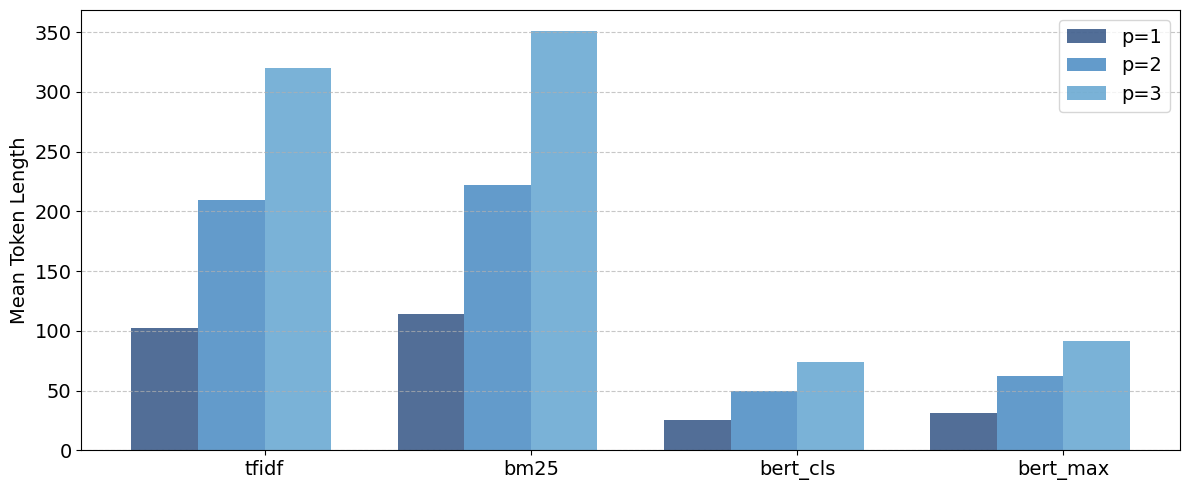

In [60]:
plot_context_token_lengths(retrievals)


#### Count tokens in corpus

In [12]:
# reading paragraphs with the created function
paragraphs = generate_paragraphs('/Users/adamwagnerhoegh/ANLPDP_exam/data/domsdatabasen.retsinformation_newer.json')

In [ ]:
# load model and tokenizer and set device
neo_tokenizer = AutoTokenizer.from_pretrained('KennethTM/gpt-neo-1.3B-danish')
t5_tokenizer = AutoTokenizer.from_pretrained('strombergnlp/dant5-large')

# creating empty lists to store token counts
neo_p_lens = []
t5_p_lens = []

# iterate through appending the token length of each paragraph
for item in tqdm(paragraphs):
    neo_p_lens.append(len(neo_tokenizer.tokenize(item['text'])))
    t5_p_lens.append(len(t5_tokenizer.tokenize(item['text'])))

/Users/adamwagnerhoegh/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
  0%|          | 0/42593 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Token indices sequence length is longer than the specified maximum sequence length for this model (1178 > 1024). Running this sequence through the model will result in indexing errors
100%|██████████| 42593/42593 [00:23<00

In [26]:
# printing mean token length of paragraphs
print(f'Mean token length of paragraph (neo): {np.mean(neo_p_lens)}')
print(f'Mean token length of paragraph (t5): {np.mean(t5_p_lens)}')


Mean token length of paragraph (neo): 132.69074730589534
Mean token length of paragraph (t5): 128.02904233089944


In [28]:
# printing total token length of corpus (by each tokenizer)
print(f'Token length of corpus (neo): {sum(neo_p_lens)}')
print(f'Token length of corpus (t5): {sum(t5_p_lens)}')

Token length of corpus (neo): 5651697
Token length of corpus (t5): 5453141


#### Testing dense cls-retrieval against random retrieval

In [6]:
# loading cls-embeddings
cls_embeddings = torch.load('/Users/adamwagnerhoegh/ANLPDP_exam/output/embeddings/cls_embeddings_DanskBERT.pt')

In [10]:
# loading paragraphs
paragraphs = generate_paragraphs('/Users/adamwagnerhoegh/ANLPDP_exam/data/domsdatabasen.retsinformation_newer.json')

In [11]:
# tweaking dense retrieval function from info_retrieval.py to create a random retrieval vector to retrieve for
def random_dense_retrieval(embeddings, corpus, pooling='cls', k=3):
    
    embedding_vector = torch.rand(1, 768)

    # normalise embeddings (to get cosine similarity from dot product)
    embedding_vector_normalised = embedding_vector / torch.norm(embedding_vector, dim=-1, keepdim=True)
    embeddings_matrix_normalised = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)

    # get paragraphs with highest similarity scores
    dense_retrieval = embeddings_matrix_normalised @ torch.transpose(embedding_vector_normalised, 0, 1)
    sorted_retrieval = torch.sort(dense_retrieval, descending=True, stable=True, dim=0)
    fixed_retrieval_list = [(item, idx) for (item, idx) in zip(sorted_retrieval[0], sorted_retrieval[1]) if torch.isnan(item) == False]
    top_k_indices = [item[1] for item in fixed_retrieval_list[:k]]
    document = [corpus[i]['text'] for i in top_k_indices]

    return document

In [30]:
# empty list to store retrievals
random_context = []

# looping through
for _ in tqdm(dev_set['question']):
    random_context.append(random_dense_retrieval(cls_embeddings, paragraphs))

100%|██████████| 103/103 [00:19<00:00,  5.23it/s]


In [32]:
# saving random retrievals

with open("random_context.json", "w") as save:
	json.dump(random_context, save)

In [24]:
# reading answers generated by neo with random (k=1) contexts
with open('output/inference/neo_gen_random_context.txt', 'r') as file:
    # Read all lines into a list
    random_answers = file.readlines()

In [32]:
# reading answers generated by neo with cls-retrieved contexts (k=1)
with open('output/inference/neo_gen_bert_cls_k1.txt', 'r') as file:
    # Read all lines into a list
    neo_k1_answer = file.readlines()

In [177]:
# pasting functions to calculate scores from eval_functions.py
def calculate_bleu(answers, gold_answers):
    scores = []
    for answer, gold_answer in zip(answers, gold_answers):
        score = sentence_bleu([gold_answer], answer, smoothing_function=SmoothingFunction().method1)
        scores.append(score)
    return scores

def calculate_rouge(answers, gold_answers):
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    for answer, gold_answer in zip(answers, gold_answers):
        scores = scorer.score(answer, gold_answer)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)
        
    return rouge1_scores, rouge2_scores, rougeL_scores

def calculate_meteor(answers, gold_answers):
    scores = []
    for answer, gold_answer in zip(answers, gold_answers):
        answer_tokens = answer.split()
        gold_answer_tokens = gold_answer.split()
        score = meteor_score([gold_answer_tokens], answer_tokens, gamma=0.0) # set gamma (word order penalty) to 0 to avoid bug where two identical sentences are not scored 1
        scores.append(score)
    return scores


In [30]:
# printing metrics for random retrieval answer
print(f"BLEU: {np.mean(calculate_bleu(random_answers, dev_set['answer']))}")
print(f"ROUGE-L: {np.mean(calculate_rouge(random_answers, dev_set['answer'])[2])}")
print(f"METEOR: {np.mean(calculate_meteor(random_answers, dev_set['answer']))}")


BLEU: 0.06535894659682062
ROUGE-L: 0.044419446900313526
METEOR: 0.07943291113182534


In [33]:
# printing metrics for cls-retrieved answer
print(f"BLEU: {np.mean(calculate_bleu(neo_k1_answer, dev_set['answer']))}")
print(f"ROUGE-L: {np.mean(calculate_rouge(neo_k1_answer, dev_set['answer'])[2])}")
print(f"METEOR: {np.mean(calculate_meteor(neo_k1_answer, dev_set['answer']))}")

BLEU: 0.1122419548289757
ROUGE-L: 0.10222230224439338
METEOR: 0.14409572606976204


#### Qualitative check of BM25 answers

In [164]:
with open('output/inference/neo_gen_bm25_k1.txt', 'r') as file:
    # Read all lines into a list
    neo_bm25_k1 = file.readlines()

with open('output/inference/t5_gen_bm25_k1.txt', 'r') as file:
    # Read all lines into a list
    t5_bm25_k1 = file.readlines()

In [234]:
# set index to zero to reset iteration below
i = 0

In [313]:
#i = np.random.randint(104)

i = 80


print(f'Index: {i}')

print(f'Question: {dev_set.loc[i, 'question']}')

print('\n')

print(f'neo: {neo_bm25_k1[i]}\n')
print(f't5: {t5_bm25_k1[i]}\n')
#print(f'retrieved text: {dev_set.loc[i, 'bm25_context'][0]}\n')
print(f'answer: {dev_set.loc[i, 'answer']}\n')
#print(f'paragraph: {dev_set.loc[i, 'text']}\n')

# print('\n')

print('NEO-SCORES')
print(f"BLEU: {np.mean(calculate_bleu(neo_bm25_k1[i], dev_set.loc[i, 'answer']))}")
print(f"ROUGE-L: {np.mean(calculate_rouge(neo_bm25_k1[i], dev_set.loc[i, 'answer'])[2])}")
print(f"METEOR: {np.mean(calculate_meteor(neo_bm25_k1[i], dev_set.loc[i, 'answer']))}")

print('\n')

print('T5-SCORES')
print(f"BLEU: {np.mean(calculate_bleu(t5_bm25_k1[i], dev_set.loc[i, 'answer']))}")
print(f"ROUGE-L: {np.mean(calculate_rouge(t5_bm25_k1[i], dev_set.loc[i, 'answer'])[2])}")
print(f"METEOR: {np.mean(calculate_meteor(t5_bm25_k1[i], dev_set.loc[i, 'answer']))}")

i += 1


Index: 80
Question: Hvad skal jord have en skadelig virkning på, hvis det skal forstås som forurenet jord?


neo: Ved forurenet jord forstås jord, der på grund af menneskelig påvirkning kan have skadelig virkning på grundvand, menneskers sundhed og miljøet i øvrigt.


t5: . Relevante paragraffer: Ved forurenet jord forstås jord, der på grund af menneskelig påvirkning kan have en skadelig virkning på menneskers sundhed og miljøet i øvrigt.. Svar:? Svar:? Svar: Ja. Svar: Ja. Svar: Ja. Svar: Ja. Beskrivelse af de relevante paragraffer: Svar: Ja. Beskrivelse af de relevante paragraffer: Svar: Ja. Beskrivelse af de relevante paragraffer: Svar: Ja. Beskrivelse af de relevante paragraffer: Svar: Ja. Beskrivelse af de relevante paragraffer: Svar: Ja. Svar: Ja. Svar: Ja. Sva


answer: Grundvand, menneskers sundhed og miljøet i øvrigt.

NEO-SCORES
BLEU: 0.007113117640155692
ROUGE-L: 0.02
METEOR: 0.02


T5-SCORES
BLEU: 0.007113117640155692
ROUGE-L: 0.04
METEOR: 0.04
